In [1]:
# | export
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
import pandas as pd

In [2]:
#| default_exp ode

# Utils Functions

In [3]:
# | export
def plot_fitted_odes(data_fitted, t_fit, measured, model_result, xlim=None, ylim=None, t_name='time'):
    import seaborn as sns
    import pandas as pd
    
    time = measured[:,0]
    x = measured[:,1:]
    df_x = pd.DataFrame(measured, columns=[t_name]+[f'x{i}' for i in range(1, x.shape[1]+1)]).melt(id_vars=t_name, value_name='count', var_name='species')
    df_x['data_type'] = ['measured'] * df_x.shape[0]
    
    df_fit = pd.DataFrame(data=data_fitted, index=pd.Series(t_fit, name=t_name), columns=[f'x{i}' for i in range(data_fitted.shape[1])]).reset_index()
    df_fit_long = df_fit.melt(id_vars=t_name, var_name='species', value_name='count')
    df_fit_long['data_type'] = ['fit'] * df_fit_long.shape[0]
    
    join_fit_x = pd.concat((df_fit_long, df_x), ignore_index=True)
    
    ax = sns.lineplot(data = join_fit_x, x=t_name, y='count', hue='species', style='data_type', markers=['.', 'o'])

    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
        
        
    report_fit(model_result)
    plt.show()
    return ax

# ODE model

models and fit functions for ODEs coming from a master equation. 
linear reaction where you just have forward rates. You can set creation rates (`kinp`) and distruction rates (`kout`) by initialize_params 


example:
$$ \xrightarrow{k_{inp}} \text{AA..AA} \xrightarrow{k_0} \text{AA..A} \xrightarrow{k_1} ... \xrightarrow{k_{n-1}} \text{AA} \xrightarrow{k_{out}}$$

This model is solved by the following system of equation 

$$
\begin{pmatrix}
\frac{dx_0}{dt}\\
\frac{dx_1}{dt}\\
..\\
\frac{dx_n}{dt}\\
\end{pmatrix}
=
\begin{bmatrix}
k_{inp} & -k_0 & 0 & .. & 0 & 0\\
0 & k_0 & -k_1 & .. & 0 & 0\\
..& .. & .. & .. & .. & ..\\
0 & 0 & 0 & .. & -k_{n-1} & 0\\
0 & 0 & 0 & .. & k_{n-1} & -k_{out}\\
\end{bmatrix}
\cdot
\begin{pmatrix}
1\\
x_0\\
..\\
x_{n-1}\\
x_{n}\\
\end{pmatrix}
$$

If kin_guess is None the model is the following

$$
\begin{pmatrix}
\frac{dx_0}{dt}\\
\frac{dx_1}{dt}\\
..\\
\frac{dx_n}{dt}\\
\end{pmatrix}
 =
\begin{bmatrix}
-k_0 & 0 & .. & 0 & 0\\
k_0 & -k_1 & .. & 0 & 0\\
.. & .. & .. & .. & ..\\
0 & 0 & .. & -k_{n-1} & 0\\
0 & 0 & .. & k_{n-1} & -k_{out}\\
\end{bmatrix}
\cdot
\begin{pmatrix}
x_0\\
x_1 \\
..\\
x_{n-1}\\
x_{n}\\
\end{pmatrix}
$$

In [4]:
#| default_exp ode

In [5]:
# | export
def initialize_params(data, initial_rate_guess='random', init_hidden=None, kout_guess=None, initial_guess_bounds=[0.0001, 1], vary_initial_conditions=True):
    """ Inizialize parameters for ODEs. 
    If initial_guess is 'random' then a vector of random variables [0,1) is created
    If kin_guess and kout_guess are None then the model doesn't include creation and distruction rate, provide a value otherwise"""
    
    if init_hidden is None:
        raise Exception('Initial hidden population needs to be provided')
    
    initial_conditions =  [init_hidden] + list(data[0,:]) 

    if initial_rate_guess == 'random':
        initial_rate_guess = np.random.rand(len(initial_conditions) -1)
        
    params = Parameters()
    
    #creation rate
    params.add('k_inp', value=0, vary=False)

    for nm,i in enumerate(initial_conditions):
        params.add('x'+str(nm)+'0', value=i, min=0, vary=vary_initial_conditions)

    # reaction rates 
    for nm, k in enumerate(initial_rate_guess):
        params.add('k'+str(nm), value=k, min=initial_guess_bounds[0], max=initial_guess_bounds[1])

    # distruction rate   
    if kout_guess == None:
        params.add('k_out', value=0, vary=False)
    else:
        params.add('k_out', value=kout_guess)
    return params

In [6]:
x = np.array([[1,1,2,3], [1, 4,5,6]])
initial_guess= [0.1, 0.2, 0.3]
test_init_params = initialize_params(x, 'random', init_hidden=100, kout_guess=0.2)

test_init_params

name,value,initial value,min,max,vary
k_inp,0.00000000,0,-inf,inf,False
x00,100.000000,100,0.00000000,inf,True
x10,1.00000000,1,0.00000000,inf,True
x20,1.00000000,1,0.00000000,inf,True
x30,2.00000000,2,0.00000000,inf,True
x40,3.00000000,3,0.00000000,inf,True
k0,0.90993157,0.9099315672865967,1.0000e-04,1.00000000,True
k1,0.51559044,0.5155904391424645,1.0000e-04,1.00000000,True
k2,0.02415433,0.02415432647900495,1.0000e-04,1.00000000,True
k3,0.69542177,0.6954217686545512,1.0000e-04,1.00000000,True


In [7]:
x = np.array([[1,2,3], [4,5,6]])
initial_guess= [0.1, 0.2, 0.3]
test_init_params = initialize_params(x, initial_guess, init_hidden=100)
assert test_init_params['k1'] == 0.2
assert test_init_params['x00'] == 100 
assert list(test_init_params.keys()) == ['k_inp','x00','x10', 'x20',  'x30', 'k0', 'k1', 'k2', 'k_out' ]

In [8]:
test_init_params

name,value,initial value,min,max,vary
k_inp,0.00000000,0,-inf,inf,False
x00,100.000000,100,0.00000000,inf,True
x10,1.00000000,1,0.00000000,inf,True
x20,2.00000000,2,0.00000000,inf,True
x30,3.00000000,3,0.00000000,inf,True
k0,0.10000000,0.1,1.0000e-04,1.00000000,True
k1,0.20000000,0.2,1.0000e-04,1.00000000,True
k2,0.30000000,0.3,1.0000e-04,1.00000000,True
k_out,0.00000000,0,-inf,inf,False


In [9]:
# | export 
def k_matrix(params):
    params_k_list = [k for k in params.keys() if 'k' in k]
    m = len(params_k_list)
    n = m - 1

    k = np.eye(n,m) - np.eye(n,m, k=1)
    k_values = [params[k] for k in params_k_list]
    return k_values * k

In [10]:
test_params = {'a':1/3,'kin':0,'k1':1,'k2':20, 'k3':300, 'kout':1}
out = np.array([[0,-1, 0, 0, 0], 
                [0,1,-20, 0, 0], 
                [0,0, 20, -300, 0], 
                [0, 0, 0, 300, -1]])
assert (k_matrix(test_params) == out).all()

In [11]:
k_matrix(test_params)

array([[   0.,   -1.,    0.,    0.,    0.],
       [   0.,    1.,  -20.,    0.,    0.],
       [   0.,    0.,   20., -300.,    0.],
       [   0.,    0.,    0.,  300.,   -1.]])

In [12]:
# | export 
def _master_equations(y, t, paras):
    """
    Your system of differential equations
    # f0 = -k0 * x1
    # f1 = k0 * x1 - k1 * x2
    # ...
    # fn-1 = kn-2 * x2 - kn-1 * x3
    # fn = kn-1 * xn-1
    fn need to be solve using odeint
    """
    y = np.insert(y, 0, 1)
    rates = k_matrix(paras)
    dydt = rates.dot(y)
    return dydt

In [13]:
test_params = {'a':1/3, 'k_in':1, 'k1':4,'k2':6, 'k3':9, 'k_out':9}
M = np.array([[1, -4, 0, 0, 0], 
              [0, 4, -6, 0, 0], 
              [0, 0, 6, -9, 0], 
              [0, 0, 0, 9, -9]])
xs = np.array([ 1/4, 1/6, 1/9, 1/3])
out = np.array([0, 0, 0, -2])
_master_equations(xs, 0, test_params)
# 

assert (_master_equations(xs, 0, test_params) == out.T).all()

In [14]:
# | export 
def ode_solver(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(_master_equations, x0, t, args=(paras,))
    return x

In [15]:
# | export 
def plot_fitted(t_fit, data_fitted, measured, model_result):
    t_measured = measured[:,0]
    x_measured =  measured[:,1:]
    # plot fitted data
    plt.plot(t_fit, data_fitted, '-', linewidth=2, color='red', label='fitted data')
    for i, xi_measured in enumerate(x_measured.T):
        plt.scatter( t_measured, xi_measured, marker='o', color='b', label= 'X' + str(i))
    plt.legend()
    plt.xlim([0, np.max(t_measured)])
    plt.ylim([0, 1.1 * np.max(data_fitted)])
    # display fitted statistics
    report_fit(model_result)

    plt.show()

In [16]:
# | export 
def residual(paras, t, data, eps=None):

    """
    compute the residual between actual data and fitted data
    """
    x0 = [paras[x].value for x in paras.keys() if 'x' in x]
    model = ode_solver(t, x0, paras)
    if eps is None:
        return ((model - data)).ravel()
    return ((model-data) / eps).ravel()

In [17]:
# | export 
def residual_hidden_states(paras, t, data, eps=None):

    """
    compute the residual between actual data and fitted data
    first column of data should be 
    """
    x0 = [paras[x].value for x in paras.keys() if 'x' in x]
    model = ode_solver(t, x0, paras)
    if eps is None:
        return ((model[:,1:] - data)).ravel()
    return ((model[:,1:] - data) / eps).ravel()

In [18]:
# | export 
def fit_ode(residual_fn, params, time, x, method='leastsq', eps=None):
    kws = {'eps':eps}
    return minimize(residual_fn, params, args=(time, x), kws=kws, method=method)

## Simulate Process no k_in k_out
Simulate the process where initial condition are unknown
$$\text{AA..AA} \xrightarrow{k_0} \text{AA..A} \xrightarrow{k_1} ... \xrightarrow{k_{n-1}} \text{AA}$$
$$X_1 \xrightarrow{k_0} X_2 \xrightarrow{k_1} ... \xrightarrow{k_{n-1}} X_n$$

In [19]:
# Simulation using kinp and kout parameters fixed to zero
# fixed error
time_limit = 10
num_chain_reaction = 4
sampling_times = list(range(time_limit))

k0 = 0.3
k1 = 0.1
k2 = 0.8


x = np.zeros((time_limit, num_chain_reaction))
x[0,:] = np.array([1000, 0, 0 , 0])

noise_dev = np.random.gamma(3, 0.8, (time_limit, 4))
scale = 0.1


for t in sampling_times[1:]:
    proc1, proc2, proc3 = np.random.normal(scale= scale), np.random.normal(scale= scale), np.random.normal(scale= scale)
    x[t, 0] = x[t-1, 0] - (x[t-1, 0] * (k0 + proc1))
    x[t, 1] = x[t-1, 1] + ((x[t-1, 0] * (k0 + proc1)) - (x[t-1, 1] * (k1 + proc2)))
    x[t, 2] = x[t-1, 2] + ((x[t-1, 1] * (k1 + proc2)) - (x[t-1, 2] * (k2 + proc3)))
    x[t, 3] = x[t-1, 3] + (x[t-1, 2] * (k2 + proc3))
x = np.abs(x)

# first population is unmeasured
measured_array = x[:,1:]

<AxesSubplot:>

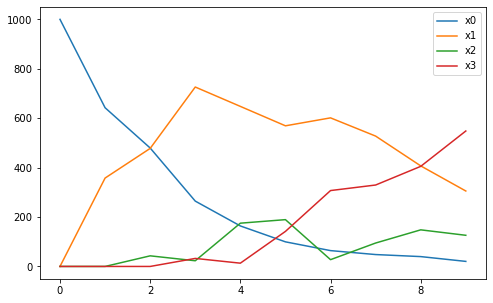

In [20]:
x_df = pd.DataFrame(x, columns = ['x0', 'x1', 'x2', 'x3'], index=sampling_times)
x_df.plot(figsize=(8,5))

<AxesSubplot:xlabel='time'>

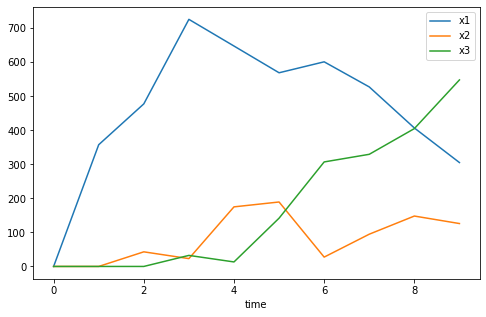

In [21]:
measured_df = pd.DataFrame(measured_array, columns = ['x1', 'x2', 'x3'], index=pd.Series(sampling_times, name='time'))
measured_df.plot(figsize=(8,5))


In [22]:
# Fit

# set measuredametermeasured_arrayounds; you can also fix parametmeasured_df(use vary=False)
params = initialize_params(measured_array, init_hidden=2000)
eps= None


# fit model
result = minimize(residual_hidden_states, params, args=(sampling_times, measured_array),kws=eps, method='leastsq')  # leastsq nelder
# check results of the fit
initial_conditions = x[0,:]
t_fit = np.linspace(0., 10., 100)
data_fitted = ode_solver(t_fit, initial_conditions, result.params)




[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 30
    # variables        = 7
    chi-square         = 84415.5686
    reduced chi-square = 3670.24211
    Akaike info crit   = 252.269292
    Bayesian info crit = 262.077674
##  Warning: uncertainties could not be estimated:
    x10:    at boundary
    x20:    at boundary
    x30:    at boundary
[[Variables]]
    k_inp:  0 (fixed)
    x00:    1010.90133 (init = 2000)
    x10:    0.00000000 (init = 0)
    x20:    0.00000000 (init = 0)
    x30:    0.00000000 (init = 0)
    k0:     0.49971384 (init = 0.9277314)
    k1:     0.13367831 (init = 0.301844)
    k2:     0.53774087 (init = 0.7803181)
    k_out:  0 (fixed)


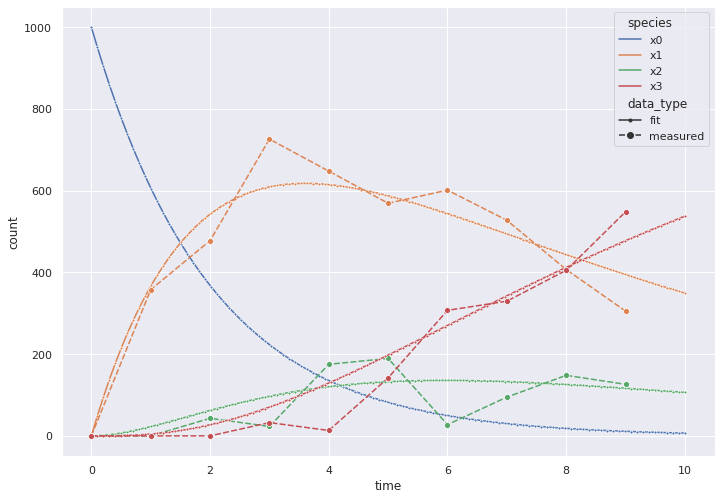

<AxesSubplot:xlabel='time', ylabel='count'>

In [23]:
# Plot fit with data 
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

plot_fitted_odes(data_fitted, t_fit, measured_df.reset_index().values, result)



## Simulate Process with k_out

In [24]:
# Simulation using kinp and kout parameters fixed to zero
# fixed error
time_limit = 20
num_chain_reaction = 4
sampling_times = list(range(time_limit))


k0 = 0.7
k1 = 0.2
k2 = 0.1
k_out = 0.8

x = np.zeros((time_limit, num_chain_reaction))
x[0,:] = np.array([400, 10, 3 , 6])

noise_dev = np.random.gamma(3, 0.8, (time_limit, 4))
scale = 0.1


for t in range(1, time_limit):
    proc0, proc1, proc2, proc3, procout = np.random.randn(5) * scale
    x[t, 0] = np.max(x[t-1, 0] - (x[t-1, 0] * (k0 + proc1)), 0)
    x[t, 1] = np.max(x[t-1, 1] + ((x[t-1, 0] * (k0 + proc1)) - (x[t-1, 1] * (k1 + proc2))), 0)
    x[t, 2] = np.max(x[t-1, 2] + ((x[t-1, 1] * (k1 + proc2)) - (x[t-1, 2] * (k2 + proc3))),0)
    x[t, 3] = np.max(x[t-1, 3] + (x[t-1, 2] * (k2 + proc3)) - (x[t-1, 3] * (k_out + procout)), 0)
x = np.abs(x)
# first population is unmeasured
measured_array = x[:,1:]

<AxesSubplot:>

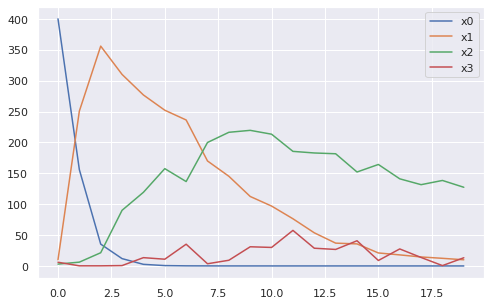

In [32]:
x_df = pd.DataFrame(x, columns = ['x0', 'x1', 'x2', 'x3'], index=sampling_times)
x_df.plot(figsize=(8,5))

In [33]:
x_df



,x0,x1,x2,x3
0,4.000000e+02,10.000000,3.000000,6.000000
1,1.558798e+02,250.658022,6.164896,0.194179
2,3.532276e+01,355.842954,21.387176,0.201583
3,1.185227e+01,310.031945,90.101829,0.607353
4,2.595602e+00,276.754893,119.228263,13.428374
5,5.774366e-01,252.091381,157.513236,10.903073
6,1.737836e-01,236.289393,136.626067,35.192919
7,6.813135e-02,169.952187,199.862020,3.542104
8,1.984717e-02,145.163300,216.353713,9.211277
9,7.123477e-03,112.452655,219.516345,31.037244


<AxesSubplot:xlabel='time'>

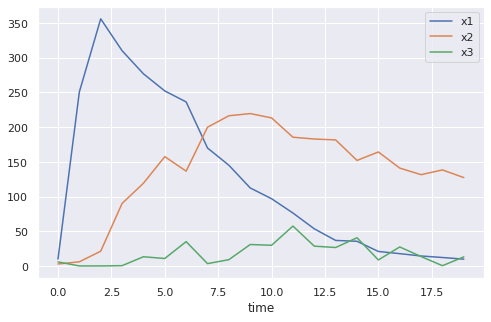

In [26]:
measured_df = pd.DataFrame(measured_array, columns = ['x1', 'x2', 'x3'], index=pd.Series(sampling_times, name='time'))
measured_df.plot(figsize=(8,5))


In [27]:
# Fit

# Parameter
params = initialize_params(measured_array, initial_rate_guess= [0.6, 0.1, 0.3], kout_guess=0.1, init_hidden=500)
eps= None


# fit model
result = minimize(residual_hidden_states, params, args=(sampling_times, measured_array),kws=eps, method='leastsq')  # leastsq nelder

# Predict
initial_conditions = x[0,:] + np.random.normal(x[0,:].shape[0], scale=1)
t_fit = np.linspace(0., 41., 100)
data_fitted = ode_solver(t_fit, initial_conditions, result.params)




[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 595
    # data points      = 60
    # variables        = 8
    chi-square         = 18006.0508
    reduced chi-square = 346.270207
    Akaike info crit   = 358.247114
    Bayesian info crit = 375.001871
[[Variables]]
    k_inp:  0 (fixed)
    x00:    445.160732 +/- 26.5469637 (5.96%) (init = 500)
    x10:    5.07522509 +/- 18.5661326 (365.82%) (init = 10)
    x20:    3.9500e-07 +/- 0.04265302 (10798266.26%) (init = 3)
    x30:    2.36458033 +/- 16.0221913 (677.59%) (init = 6)
    k0:     0.98968837 +/- 0.13989879 (14.14%) (init = 0.6)
    k1:     0.16305061 +/- 0.00756483 (4.64%) (init = 0.1)
    k2:     0.10699609 +/- 0.00790756 (7.39%) (init = 0.3)
    k_out:  0.67438195 +/- 0.13350641 (19.80%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(x00, x10)   = -0.706
    C(k0, k1)     = -0.635
    C(k1, k2)     = 0.590
    C(x00, x20)   = 0.496
    C(x00, k2)    = 0.490
    C(k0, k2)    

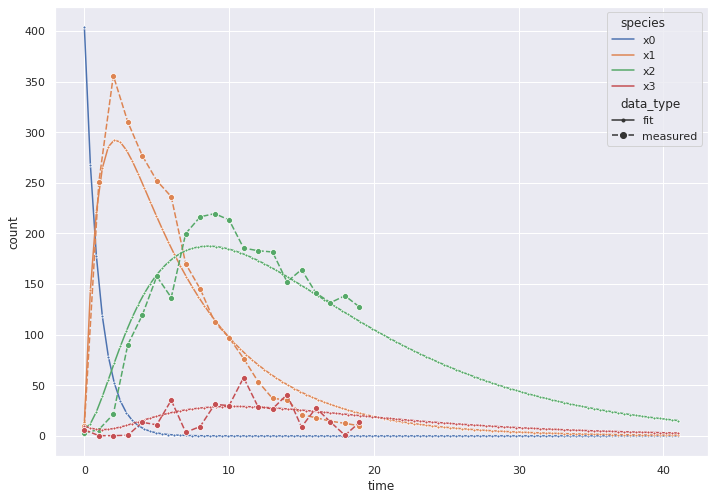

<AxesSubplot:xlabel='time', ylabel='count'>

In [28]:
# Plot fit with data 
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

plot_fitted_odes(data_fitted, t_fit, measured_df.reset_index().values, result)



In [29]:
# | export 

In [30]:
# | export 

In [31]:
#| hide
import nbdev; nbdev.nbdev_export()